## Import the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from os import path
from timeit import default_timer as timer
import sys

In [2]:
sys.path.append(path.abspath('../src/3d/'))

In [3]:
from motion_integration import integrate_motion, evaluate_motion_equations, matrix_to_angles, angles_to_matrix, nondimensionalize
from binding_expt import parse_file

## Initialize global variables

In [4]:
t_span = (0, 50)
n_steps = 250
init = np.array([1.2, 0, 0, 1., 0, 0])
domain='wall'

In [5]:
def exact_vels(em):
    v = np.zeros((6,))
    v[4] = -1
    return v

### Run the RK integrator for a free platelet

In [6]:
n_nodes = 8
order = 'radau'
adaptive = False

In [7]:
evaluate_motion_equations.counter = 0
start_r = timer()
result_r = integrate_motion(t_span, n_steps, init, exact_vels, n_nodes=n_nodes, order=order,
                            adaptive=adaptive, a=1.5, b=0.5, domain=domain)
end_r = timer()

4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
10 0 3 RK23
14 0 5 RK23
14 0 5 RK23
14 0 5 RK23
14 0 5 RK23
14 0 5 RK23
14 0 5 RK23
14 0 5 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 0 2 RK23
4 

In [8]:
x1r, x2r, x3r, r_matricesr, errsr = result_r[:5]
tr = result_r[9]
count_r = evaluate_motion_equations.counter

### Run the explicit integrator for a free platelet

In [9]:
n_nodes = 8
order = '2nd'
adaptive = False

In [10]:
evaluate_motion_equations.counter = 0
start_e = timer()
result_e = integrate_motion(t_span, n_steps, init, exact_vels, n_nodes=n_nodes, order=order,
                            adaptive=adaptive, a=1.5, b=0.5, domain=domain)
end_e = timer()

In [11]:
x1e, x2e, x3e, r_matricese, errse = result_e[:5]
te = result_e[9]
count_e = evaluate_motion_equations.counter

### Run an explicit RK without checkpointing

In [6]:
n_nodes = 8
r_hat = np.array([[0, 1, 0], [0, 0, -1], [-1, 0, 0]])
r_matrix = np.eye(3)
x1, x2, x3 = init[:3]
b_matrix = np.dot(r_matrix, r_hat.T)
angles = matrix_to_angles(r_hat)
a, b = 1.5, 0.5

In [7]:
def fun(t, y, b_matrix):
    func_center = y[:3]
    fun_angles = y[3:]

    r_hat_tmp = angles_to_matrix(fun_angles)
    rmat_temp = np.dot(b_matrix, r_hat_tmp)

    func_forces, func_torques = np.zeros((3,)), np.zeros((3,))
    # func_point, func_rep_force = repulsive_force(func_center[0], rmat_temp[:, 0])
    # func_forces += np.array([func_rep_force, 0, 0])
    # func_torques += np.cross(
    #     [func_point[0] - func_center[0], func_point[1], func_point[2]],
    #     [func_rep_force, 0, 0])

    func_result = evaluate_motion_equations(
        func_center[0], rmat_temp[:, 0], func_forces, func_torques, exact_vels, a=a, b=b, n_nodes=n_nodes,
        domain=domain, proc=1)
    d_rmat = np.cross(func_result[3:6], rmat_temp, axisb=0, axisc=0)
    d_rm_hat = np.linalg.solve(b_matrix, d_rmat)
    s1, s2, s3 = np.sin(fun_angles)
    c1, c2, c3 = np.cos(fun_angles)
    d_beta = d_rm_hat[1, 0] / c2
    d_alpha = (d_rm_hat[0, 0] + c1 * s2 * d_beta) / (-s1 * c2)
    d_gamma = (d_rm_hat[1, 1] + s2 * c2 * d_beta) / (-c2 * s3)
    dy = np.concatenate((func_result[:3], [d_alpha], [d_beta], [d_gamma]))
    return dy

In [8]:
center = np.array([x1, x2, x3])
y0 = np.concatenate((center, angles))
t_current = t_span[0]
sol_list = []
b_matrices = [b_matrix]
evaluate_motion_equations.counter = 0

In [9]:
def event1(t, y):
    return np.abs(y[4]) - np.pi / 2 + np.pi / 16
def event2(t, y):
    return np.abs(y[3]) - np.pi + np.pi / 16
def event3(t, y):
    return np.abs(y[5]) - np.pi + np.pi / 16

events = [event1, event2, event3]
for e in events:
    e.terminal = 1

In [10]:
start = timer()
while True:
    def ivp_fun(t, y):
        return fun(t, y, b_matrix)
    
    sol = solve_ivp(ivp_fun, (t_current, t_span[1]), y0, events=events)
    sol_list.append(sol)
    
    print(sol.status)
    
    if sol.status == 0:
        break
    
    rmat_hat = angles_to_matrix(sol.y[3:, -1])
    r_matrix = np.dot(b_matrix, rmat_hat)
    b_matrix = np.dot(r_matrix, r_hat.T)
    b_matrices.append(b_matrix)
    y0 = np.concatenate((sol.y[:3, -1], matrix_to_angles(r_hat)))
    t_current = sol.t[-1]
end = timer()

1


AssertionError: 

In [18]:
t_list = [sol_list[0].t[0, None]]
center_list = [sol_list[0].y[:3, 0, None]]
rmat_list = [np.dot(b_matrices[0], angles_to_matrix(sol_list[0].y[3:, 0]))]
for sol, bmat in zip(sol_list, b_matrices):
    t_list.append(sol.t[1:])
    center_list.append(sol.y[:3, 1:])
    for angles in sol.y[3:, 1:].T:
        print(angles)
        rmat_hat = angles_to_matrix(angles)
        rmat_list.append(np.dot(bmat, rmat_hat))

[ 1.57079633e+00 -5.39788557e-05  1.57079633e+00]
[ 1.57079633e+00 -5.93768510e-04  1.57079615e+00]
[ 1.57079633 -0.00599279  1.57077837]
[ 1.57079633 -0.03275223  1.57026025]
[ 1.57079633 -0.07967399  1.56763043]
[ 1.57079633 -0.14768174  1.55998169]
[ 1.57079633 -0.22785101  1.54531984]
[ 1.57079633 -0.32108348  1.52107089]
[ 1.57079633 -0.4330797   1.48287722]
[ 1.57079633 -0.56838329  1.42627788]
[ 1.57079633 -0.73286359  1.34854595]
[ 1.57079633 -0.94306072  1.25270326]
[ 1.57079633 -1.09424712  1.20478031]
[ 1.57079633 -1.26789444  1.2009795 ]
[ 1.57079633 -1.37444679  1.24540491]
[ 1.57147144 -0.00200102  1.570795  ]
[ 1.57829782 -0.02223044  1.57063263]
[ 1.60615951 -0.10441293  1.5672044 ]
[ 1.64967637 -0.22943611  1.55388914]
[ 1.70794165 -0.38493909  1.52607761]
[ 1.77863239 -0.54881544  1.48950147]
[ 1.87666821 -0.72877537  1.45422676]
[ 1.96871469 -0.85460795  1.44548189]
[ 2.0723473  -0.95915461  1.46043739]
[ 2.16879035 -1.03115035  1.49144733]
[ 2.27970685 -1.09288706  

In [19]:
np.stack(rmat_list, axis=-1).shape

(3, 3, 75)

In [20]:
t = np.concatenate(t_list)
center = np.concatenate(center_list, axis=-1)
r_matrices = np.stack(rmat_list, axis=-1)
count = evaluate_motion_equations.counter

print(t.shape, center.shape, r_matrices.shape)

(75,) (3, 75) (3, 3, 75)


In [21]:
print(sol.nfev, sol.njev, len(sol.t))

56 0 16


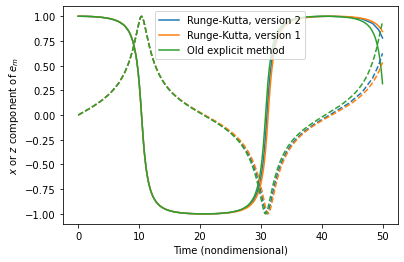

In [22]:
fig, ax = plt.subplots()
ax.plot(t, r_matrices[0, 0, :], color='C0')
ax.plot(tr, r_matricesr[0, 0, :], color='C1')
ax.plot(te, r_matricese[0, 0, :], color='C2')
ax.plot(t, r_matrices[2, 0, :], color='C0', linestyle='--')
ax.plot(tr, r_matricesr[2, 0, :], color='C1', linestyle='--')
ax.plot(te, r_matricese[2, 0, :], color='C2', linestyle='--')
plt.legend(['Runge-Kutta, version 2', 'Runge-Kutta, version 1', 'Old explicit method'])
plt.xlabel('Time (nondimensional)')
plt.ylabel('$x$ or $z$ component of $e_m$')
plt.savefig(path.expanduser('~/Desktop/xz_cmps.png'), bbox_inches='tight')
plt.show()

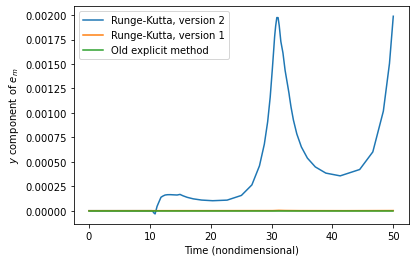

In [23]:
plt.plot(t, r_matrices[1, 0, :])
plt.plot(tr, r_matricesr[1, 0, :])
plt.plot(te, r_matricese[1, 0, :])
plt.legend(['Runge-Kutta, version 2', 'Runge-Kutta, version 1', 'Old explicit method'])
plt.xlabel('Time (nondimensional)')
plt.ylabel('$y$ component of $e_m$')
plt.savefig(path.expanduser('~/Desktop/y_cmps.png'), bbox_inches='tight')
plt.show()

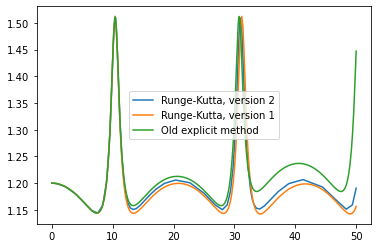

In [24]:
plt.plot(t, center[0])
plt.plot(tr, x1r)
plt.plot(te, x1e)
plt.legend(['Runge-Kutta, version 2', 'Runge-Kutta, version 1', 'Old explicit method'])
plt.savefig(path.expanduser('~/Desktop/x_position.png'), bbox_inches='tight')
plt.show()

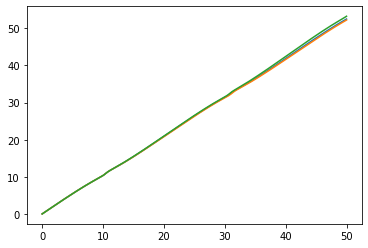

In [25]:
plt.plot(t, center[2])
plt.plot(tr, x3r)
plt.plot(te, x3e)

In [26]:
print(count_r, count_e, count)

1152 620 351


In [27]:
print(end_r - start_r, end_e - start_e, end - start)

298.204332282 157.61640573700004 13.83177776499997


In [ ]:
sol_list[1].y[3:, 0]

## Test immediately after a bond forms

In [ ]:
with np.load('../data/bd_run/bd_run005.npz') as data:
    x05, y05, z05 = data['x'], data['y'], data['z']
    t05, rmat05 = data['t'], data['r_matrices']
    receptors, ba05 = data['receptors'], data['bond_array']

In [ ]:
pars = parse_file('bd_run005')

shear = pars['shear']
sig, sig_ts, l_sep = pars['sig'], pars['sig_ts'], pars['l_sep']
dimk0_on, dimk0_off = 0, 0
check_bonds, one_side = pars['check_bonds'], pars['one_side']

In [ ]:
i = np.nonzero(ba05[0, 0, :] > 0)[0][0]
ti = t05[i]
xi, yi, zi = x05[i], y05[i], z05[i]
ri = rmat05[:, :, i]
bi = ba05[ba05[:, 0, i] > -1, :, i]

In [ ]:
t_span = (ti, ti + .02)
num_steps = 10
center = np.array([xi, yi, zi])
init = np.concatenate((center, ri.flatten()))

In [ ]:
t_sc, f_sc, lam, k0_on, k0_off, eta, eta_ts, kappa = nondimensionalize(
        l_scale=1, shear=shear, mu=4e-3, l_sep=l_sep, dimk0_on=dimk0_on,
        dimk0_off=dimk0_off, sig=sig, sig_ts=sig_ts, temp=310.)

In [ ]:
result = integrate_motion(
    t_span, num_steps, init, exact_vels, n_nodes, a=a, b=b, domain=domain, 
    adaptive=False, receptors=receptors, bonds=bi, eta=eta, eta_ts=eta_ts,
    kappa=kappa, lam=lam, k0_on=k0_on, k0_off=k0_off, check_bonds=check_bonds,
    one_side=one_side
)

In [ ]:
result[9]

In [ ]:
plt.plot(result[9], result[0])
plt.show()